<a href="https://colab.research.google.com/github/SaumilShah-7/Airbus-Ship-Detection-Challenge-Kaggle/blob/master/Airbus_Ship_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import seaborn as sns
from sklearn.model_selection import train_test_split

2.0.0


In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c airbus-ship-detection

  0% 0.00/274k [00:00<?, ?B/s]
100% 274k/274k [00:00<00:00, 41.0MB/s]
 28% 5.00M/18.0M [00:00<00:00, 32.5MB/s]
100% 18.0M/18.0M [00:00<00:00, 86.7MB/s]
100% 2.12G/2.12G [00:22<00:00, 162MB/s]
100% 2.12G/2.12G [00:22<00:00, 101MB/s]
100% 26.4G/26.4G [03:36<00:00, 200MB/s]
100% 26.4G/26.4G [03:36<00:00, 131MB/s]


In [0]:
!unzip -q train_v2.zip -d train
!unzip -q train_ship_segmentations_v2.csv.zip -d train_ship_segmentations
!unzip -q test_v2.zip -d test

!rm -rf train_v2.zip
!rm -rf train_ship_segmentations_v2.csv.zip
!rm -rf test_v2.zip

192556 192556
     Count     Count
0   150000  0.778994
1    27104  0.140759
2     7674  0.039853
3     2954  0.015341
4     1622  0.008424
5      925  0.004804
6      657  0.003412
7      406  0.002108
8      318  0.001651
9      243  0.001262
10     168  0.000872
11     144  0.000748
12     124  0.000644
14      76  0.000395
13      75  0.000389
15      66  0.000343


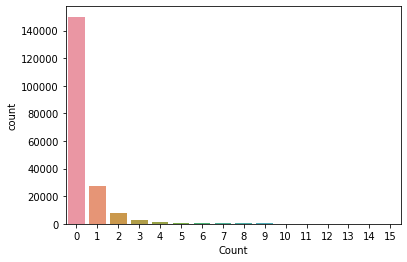

In [5]:
df = pd.read_csv('train_ship_segmentations/train_ship_segmentations_v2.csv')

print(len(df['ImageId'].unique()), len([name for name in os.listdir('train')]))

df['Count'] = df['EncodedPixels'].notnull()*1
df_h = df.groupby(['ImageId'])['Count'].sum()

print(pd.concat([df_h.value_counts(), df_h.value_counts(normalize=True)], axis=1))
sns.countplot(df_h)

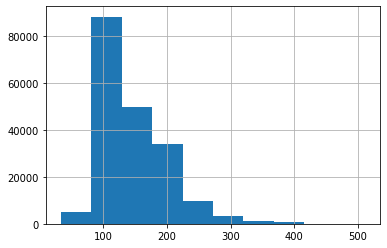

In [19]:
df_u = pd.DataFrame({'ImageId': df_h.index, 'Shipnum': df_h.values})
df_u['Filesize'] = df_u['ImageId'].apply(lambda x: os.path.getsize('train/'+x)/1024)
df_u = df_u[(df_u['Filesize'] > 50) | (df_u['Shipnum'] > 0)]
df_u['Filesize'].hist()

In [0]:
image_height = 768
image_width = 768

def rle_decode(img_id):
  img_rle = [*df.loc[df['ImageId']==img_id]['EncodedPixels']]
  mask = np.zeros(image_height*image_width, dtype=np.uint8)
  for x in img_rle:
    x = x.split(' ')
    for i in range(0, len(x), 2):
      mask[int(x[i]):int(x[i])+int(x[i+1])]=255
  return Image.fromarray(mask.reshape(image_height, image_width).astype(np.uint8).T)

In [0]:
from IPython.display import display

# print(df_u[df_u==5])

img = Image.open('train/000194a2d.jpg')
display(img)

img1 = rle_decode('000194a2d.jpg')
display(img1)

In [20]:
train_df, test_df = train_test_split(df_u, test_size=0.2, stratify=df_u['Shipnum'])
print(train_df.shape[0], test_df.shape[0])

153479 38370


In [0]:
if not os.path.exists('mask'):
  os.makedirs('mask')

for name in os.listdir('train'):
  if df_h[name]!=0:
    img = rle_decode(name)
    img.save('mask/'+name, 'JPEG')